# Crosstalk ploting
1. time evolution of expectation of $ \sigma_z(t)$ 

Running QuTiP simulation (isolated system - Schrödinger equation)...
Simulation complete.


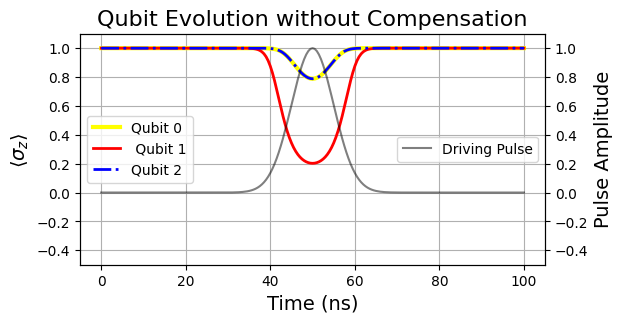

In [45]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# --- 1. SETUP THE SIMULATION (NANOSECOND SCALE) ---

# System parameters
N = 3
qubit_c = 1
w_q = 5.0 * 2 * np.pi        # Qubit frequency in rad/ns (i.e., 5 GHz)
Omega_c = 10.0 * 2 * np.pi   # Rabi frequency in rad/ns (i.e., 10 GHz)
J_coupling = 0.2* Omega_c   # Induced coupling strength

# Pulse parameters (in nanoseconds)
t_total = 100.0
t0 = 50.0
tau = 5.0

def pulse_shape(t, args):
    """Gaussian pulse envelope."""
    return np.exp(-(t - args['t0'])**2 / (2 * args['tau']**2))

# --- 2. CONSTRUCT HAMILTONIAN AND OPERATORS ---

# Pauli operators for each qubit
sx = [qt.tensor([qt.qeye(2)]*i + [qt.sigmax()] + [qt.qeye(2)]*(N-1-i)) for i in range(N)]
sz = [qt.tensor([qt.qeye(2)]*i + [qt.sigmaz()] + [qt.qeye(2)]*(N-1-i)) for i in range(N)]
# sm = [qt.tensor([qt.qeye(2)]*i + [qt.sigmam()] + [qt.qeye(2)]*(N-1-i)) for i in range(N)] # Not needed for sesolve

# Drift Hamiltonian
H_drift = -0.5 * w_q * sz[0] - 0.5 * w_q * sz[1] - 0.5 * w_q * sz[2]

# Control and Crosstalk Hamiltonian operators
H_control_op = Omega_c * sx[qubit_c]
H_crosstalk_op = J_coupling * (sx[qubit_c-1] * sx[qubit_c] + sx[qubit_c] * sx[qubit_c+1])
H = [H_drift, [H_control_op + H_crosstalk_op, pulse_shape]]



psi0 = qt.tensor(qt.basis(2,0), qt.basis(2,0), qt.basis(2,0))
tlist = np.linspace(0, t_total, 201)
args = {'t0': t0, 'tau': tau}

print("Running QuTiP simulation (isolated system - Schrödinger equation)...")
# CHANGE mesolve TO sesolve AND REMOVE c_ops ARGUMENT
result = qt.sesolve(H, psi0, tlist, e_ops=[sz[0], sz[1], sz[2]], args=args)
print("Simulation complete.")

# --- 4. PLOTTING (remains largely the same) ---
exp_sz0 = result.expect[0]
exp_sz1 = result.expect[1]
exp_sz2 = result.expect[2]
times = tlist

# --- 1. COMPUTE PULSE VALUES FOR PLOTTING ---
pulse_vals = [pulse_shape(t, args) for t in times]

# --- 2. CREATE THE STATIC PLOT ---
fig, ax1 = plt.subplots(figsize=(6, 3))

ax1.plot(times, exp_sz0, label='Qubit 0', color='yellow', linestyle='-', linewidth=3)
ax1.plot(times, exp_sz1, label=' Qubit 1', color='red', linestyle='-', linewidth=2)
ax1.plot(times, exp_sz2, label='Qubit 2', color='blue', linestyle='-.', linewidth=2)

ax1.set_xlabel('Time (ns)', fontsize=14)
ax1.set_ylabel(r'$\langle \sigma_z \rangle$', fontsize=14)
ax1.set_title('Qubit Evolution without Compensation', fontsize=16)
ax1.legend(loc='center left')
ax1.grid(True)
ax1.set_ylim(-0.5, 1.1)

# --- 3. OVERLAY THE PULSE SHAPE ---
ax2 = ax1.twinx()
ax2.plot(times, pulse_vals, label='Driving Pulse', color='black', alpha=0.5)
ax2.set_ylabel('Pulse Amplitude', fontsize=14)
ax2.legend(loc='right')
ax2.set_ylim(-0.5, 1.1)

plt.show()


Running QuTiP simulation (isolated system with compensation)...
Simulation complete.


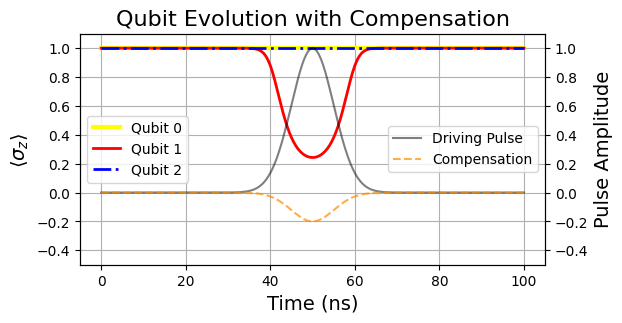

In [46]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

# --- 1. SETUP THE SIMULATION (NANOSECOND SCALE) ---

N = 3
qubit_c = 1
w_q = 5.0 * 2 * np.pi
Omega_c = 10.0 * 2 * np.pi
J_coupling = 0.2 * Omega_c
Omega_comp = J_coupling

t_total = 100.0
t0 = 50.0
tau = 5.0

def pulse_shape(t, args):
    return np.exp(-(t - args['t0'])**2 / (2 * args['tau']**2))

def comp_pulse_shape(t, args):
    return np.exp(-(t - args['t0'])**2 / (2 * args['tau']**2))

# --- 2. HAMILTONIAN SETUP ---

sx = [qt.tensor([qt.qeye(2)]*i + [qt.sigmax()] + [qt.qeye(2)]*(N-1-i)) for i in range(N)]
sz = [qt.tensor([qt.qeye(2)]*i + [qt.sigmaz()] + [qt.qeye(2)]*(N-1-i)) for i in range(N)]

H_drift = -0.5 * w_q * sz[0] - 0.5 * w_q * sz[1] - 0.5 * w_q * sz[2]
H_control_op = Omega_c * sx[qubit_c]
H_crosstalk_op = J_coupling * (sx[qubit_c-1] * sx[qubit_c] + sx[qubit_c] * sx[qubit_c+1])
H_compensation_op = -Omega_comp * (sx[qubit_c-1] * sx[qubit_c] + sx[qubit_c] * sx[qubit_c+1])

H = [
    H_drift,
    [H_control_op + H_crosstalk_op, pulse_shape],
    [H_compensation_op, comp_pulse_shape]
]

psi0 = qt.tensor(qt.basis(2,0), qt.basis(2,0), qt.basis(2,0))
tlist = np.linspace(0, t_total, 201)
args = {'t0': t0, 'tau': tau}

print("Running QuTiP simulation (isolated system with compensation)...")
result = qt.sesolve(H, psi0, tlist, e_ops=[sz[0], sz[1], sz[2]], args=args)
print("Simulation complete.")

# --- 3. EXTRACT AND COMPUTE DATA FOR PLOTTING ---

exp_sz0 = result.expect[0]
exp_sz1 = result.expect[1]
exp_sz2 = result.expect[2]
times = tlist

pulse_vals = [pulse_shape(t, args) for t in times]
comp_vals = [-(Omega_comp / Omega_c) * pulse_shape(t, args) for t in times]

# --- 4. STATIC PLOT USING FIRST SCRIPT’S STYLE ---

fig, ax1 = plt.subplots(figsize=(6, 3))

ax1.plot(times, exp_sz0, label='Qubit 0', color='yellow', linestyle='-', linewidth=3)
ax1.plot(times, exp_sz1, label='Qubit 1', color='red', linestyle='-', linewidth=2)
ax1.plot(times, exp_sz2, label='Qubit 2', color='blue', linestyle='-.', linewidth=2)

ax1.set_xlabel('Time (ns)', fontsize=14)
ax1.set_ylabel(r'$\langle \sigma_z \rangle$', fontsize=14)
ax1.set_title('Qubit Evolution with Compensation', fontsize=16)
ax1.legend(loc='center left')
ax1.grid(True)
ax1.set_ylim(-0.5, 1.1)

# Overlay pulse shape
ax2 = ax1.twinx()
ax2.plot(times, pulse_vals, label='Driving Pulse', color='black', alpha=0.5)
ax2.plot(times, comp_vals, '--', label='Compensation', color='darkorange', alpha=0.7)
ax2.set_ylabel('Pulse Amplitude', fontsize=14)
ax2.legend(loc='right')
ax2.set_ylim(-0.5, 1.1)

plt.show()
